# Тестовое задание. Смирнов Н.В.

## 1.Формулировка задачи

Задача: Разработать модель предсказания в каждом регионе объема продаж в штуках любого, выбранного вами, вида банки напитка Coca Cola.
Модель должна предсказывать объем продаж на каждый час следующих суток (от последней даты транзакции в датасете).

Про виды банок в данных ничего нет, может быть вид банки зависит от цены, и мне самому нужно их найти? Для этого нужно провести какую-то кластерицацию по цене?    
Но банки колы бывают только одного вида: 0,33 литра. И стоят они от 25 (в прошлом) до 100 рублей (сейчас). 

Описание полей в датасете:          
item_id // Id транзакции           
receipt_id // Id чека          
device_id // Id кассового аппарата          
local_date // Дата и время покупки        
barcode // Штрихкод (Штрихкод на банке? Штрих-коды уникальны для каждого вида товара, а не для каждого экземпляра.)          
price // Цена покупки, рубли (Я так понял, цена одной банки, иначе было бы слово стоимость)        
quantity // Количество купленного товара, шт.         
region // Регион      

## 2.Посмотрим на данные

In [1]:
import pandas as pd

In [2]:
data_path = r'dataset.csv'

data = pd.read_csv(data_path)

In [3]:
data

,Unnamed: 0,item_id,receipt_id,device_id,local_date,barcode,price,quantity,region
0,0,11660931229,7364786357,352402250963288,2021-02-02 00:00:01,46200310,133.0,1.0,Нижегородская область
1,1,11660931230,7364786357,352402250963288,2021-02-02 00:00:01,4601501425437,100.0,1.0,Нижегородская область
2,2,11660931245,7364786362,352403362581574,2021-02-02 00:00:04,NaN,50.0,1.0,Москва
3,3,11660931313,7364786391,352399468048288,2021-02-02 01:00:11,NaN,29.0,1.0,Ульяновская область
4,4,11660931336,7364786406,352401023174844,2021-02-02 00:00:17,NaN,250.0,1.0,Москва
...,...,...,...,...,...,...,...,...,...
2246089,2246089,11660931038,7364786218,352405756881967,2021-02-01 23:59:35,46221599,105.0,1.0,Воронежская область
2246090,2246090,11660931098,7364786258,352400866634268,2021-02-01 23:59:46,NaN,1700.0,0.1,Краснодарский край
2246091,2246091,11660931118,7364786270,352402818554872,2021-02-01 23:59:42,46204837,135.0,1.0,Москва
2246092,2246092,11660931119,7364786270,352402818554872,2021-02-01 23:59:42,2000000000015,32.0,0.5,Москва


### 1) Порассуждаем

Так, здесь строка - это конкретная покупка нашего товара (банка колы). Эти покупки имеют своё конкретное время с точностью до секунды, свой id, конкретный аппарат оплаты, чек, штрихкод, цену, кольчество товара в штуках и регион.
Нам нужно удалить то, что точно не относится к делу: "Unnamed: 0", "item_id", "receipt_id", "device_id", "barcode".
Мы должны предсказывать объем продаж на каждый час следующих суток в каждом регионе. Так что "device_id" нам не нужен, мы бы пользовались им, если бы смотрели продажи в каждом магазине.
Раз мы будем предсказывать по часам, нам нужно суммировать количестыо товара по часам.

Посмотрим, сколько уникальных штриз-кодов? Может это прольёт свет на то, какие бывает виды банок?

In [4]:
data['barcode'].unique()

array(['46200310', '4601501425437', nan, ..., '4670001094795',
       '4025700001030', '4607029053251'], dtype=object)

In [5]:
(data['barcode'].unique()).shape

(156858,)

Похоже, он нам ничем не поможет.

### 2) Удалим ненужные столбцы

In [6]:
# Удаление ненужных столбцов
columns_to_drop = ["item_id", "receipt_id", "device_id", "barcode"]
# "Unnamed: 0" оставим, будет вместо id
data.drop(columns=columns_to_drop, inplace=True)

In [7]:
data

,Unnamed: 0,local_date,price,quantity,region
0,0,2021-02-02 00:00:01,133.0,1.0,Нижегородская область
1,1,2021-02-02 00:00:01,100.0,1.0,Нижегородская область
2,2,2021-02-02 00:00:04,50.0,1.0,Москва
3,3,2021-02-02 01:00:11,29.0,1.0,Ульяновская область
4,4,2021-02-02 00:00:17,250.0,1.0,Москва
...,...,...,...,...,...
2246089,2246089,2021-02-01 23:59:35,105.0,1.0,Воронежская область
2246090,2246090,2021-02-01 23:59:46,1700.0,0.1,Краснодарский край
2246091,2246091,2021-02-01 23:59:42,135.0,1.0,Москва
2246092,2246092,2021-02-01 23:59:42,32.0,0.5,Москва


### 3) Посмотрим на типы данных

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2246094 entries, 0 to 2246093
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   local_date  object 
 2   price       float64
 3   quantity    float64
 4   region      object 
dtypes: float64(2), int64(1), object(2)
memory usage: 85.7+ MB


### 4) Пропуски

Посмотрим, есть ли они?

In [9]:
data.isnull().sum()

Unnamed: 0       0
local_date       0
price            0
quantity         0
region        1020
dtype: int64

In [10]:
print(f"Количество строк до удаления пропусков: {data.shape[0]}")

Количество строк до удаления пропусков: 2246094


Надо удалять. У нас ещё очень много значений. 

In [11]:
# Удаление строк с пропущенными значениями
data.dropna(inplace=True)

In [12]:
print(f"Количество строк после удаления пропусков: {data.shape[0]}")

Количество строк после удаления пропусков: 2245074


In [13]:
data.isnull().sum()

Unnamed: 0    0
local_date    0
price         0
quantity      0
region        0
dtype: int64

In [14]:
data

,Unnamed: 0,local_date,price,quantity,region
0,0,2021-02-02 00:00:01,133.0,1.0,Нижегородская область
1,1,2021-02-02 00:00:01,100.0,1.0,Нижегородская область
2,2,2021-02-02 00:00:04,50.0,1.0,Москва
3,3,2021-02-02 01:00:11,29.0,1.0,Ульяновская область
4,4,2021-02-02 00:00:17,250.0,1.0,Москва
...,...,...,...,...,...
2246089,2246089,2021-02-01 23:59:35,105.0,1.0,Воронежская область
2246090,2246090,2021-02-01 23:59:46,1700.0,0.1,Краснодарский край
2246091,2246091,2021-02-01 23:59:42,135.0,1.0,Москва
2246092,2246092,2021-02-01 23:59:42,32.0,0.5,Москва


### 5) Выбросы

#### a) Цена

Построим ящики с усами.

In [15]:
import matplotlib.pyplot as plt

def box_plot(feature, title, xlabel):
    # Построение ящика с усами 
    plt.figure(figsize=(10, 6))
    plt.boxplot(data['price'], vert=False)  # График горизонтальный
    plt.title(title)
    plt.xlabel(xlabel)
    plt.grid(axis='x')  # Добавление сетки по оси X
    plt.show()

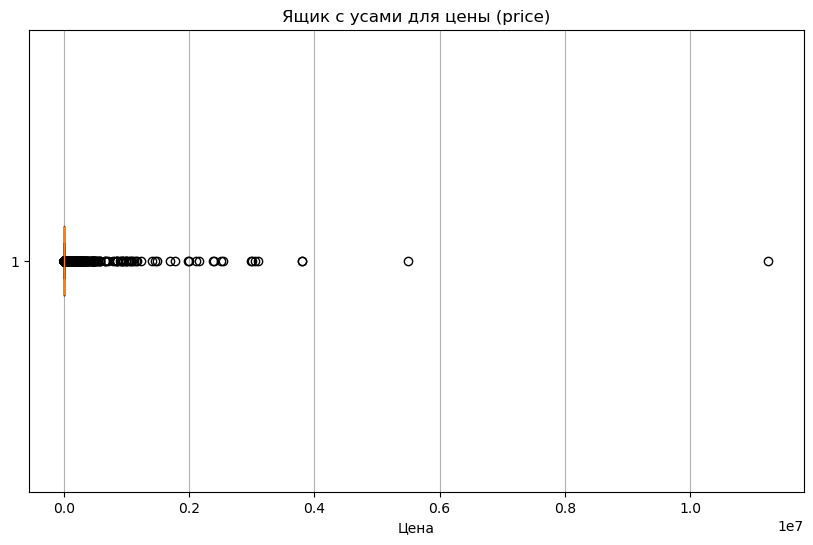

In [16]:
box_plot(data['price'], 'Ящик с усами для цены (price)', 'Цена')

Огромные выбросы. Надо отрезать.

Интересно. Я так понимаю, price, это цена одной банки.     
Удаляем выбросы дальше, посмотрим, сколько останется значений.

In [17]:
# Вычисление IQR для определения выбросов
Q1 = data['price'].quantile(0.25)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

# Определение границ для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Удаление выбросов
data_cut = data[(data['price'] >= lower_bound) & (data['price'] <= upper_bound)]

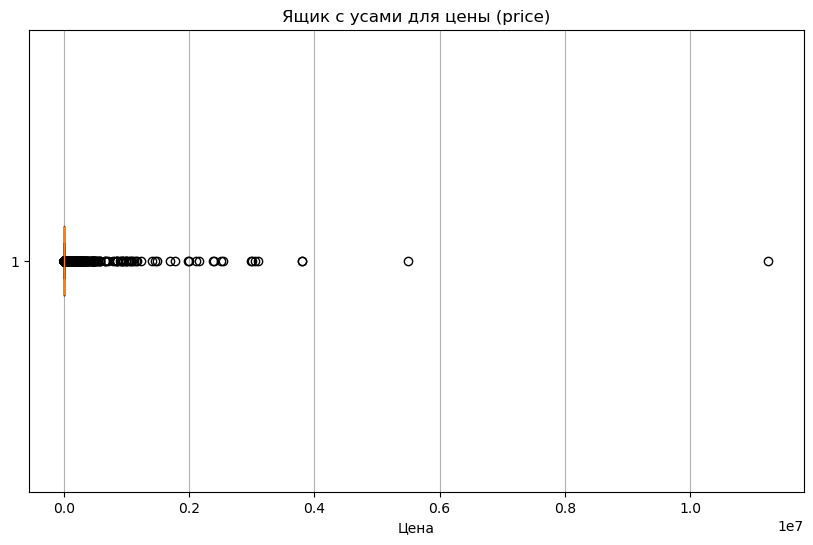

In [18]:
box_plot(data_cut['price'], 'Ящик с усами для цены (price)', 'Цена')

In [19]:
data_cut = data_cut[data_cut['price'] < 100]

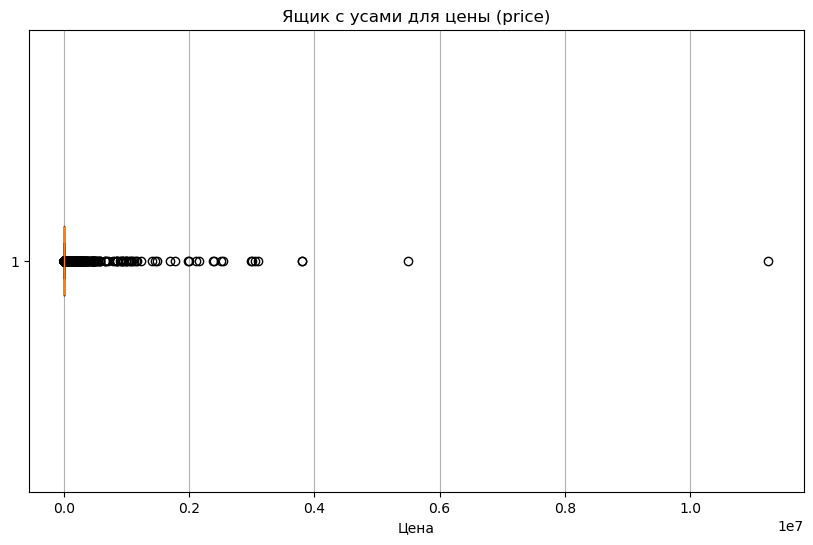

In [20]:
box_plot(data_cut['price'], 'Ящик с усами для цены (price)', 'Цена')

Банок колы дороже 150 рублей вроде пока не бывает.     
Посмотрим что там с обратного конца.

In [21]:
(data_cut[data_cut['price'] == 0]).shape

(8769, 5)

Ну это ужас. Надо тоже обрезать. Ну пусть будет 30 рублей. 

In [22]:
data_cut = data_cut[data_cut['price'] > 30]

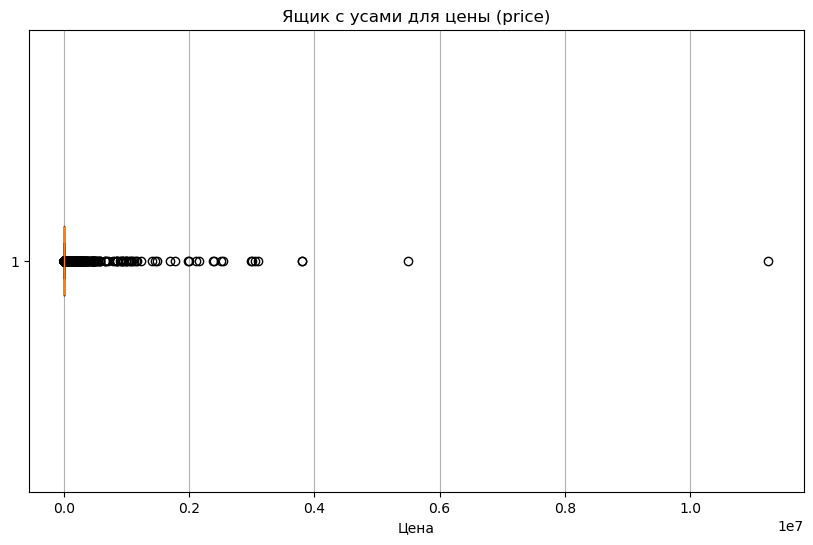

In [23]:
box_plot(data_cut['price'], 'Ящик с усами для цены (price)', 'Цена')

In [24]:
data_cut.shape

(668827, 5)

#### b) Количество

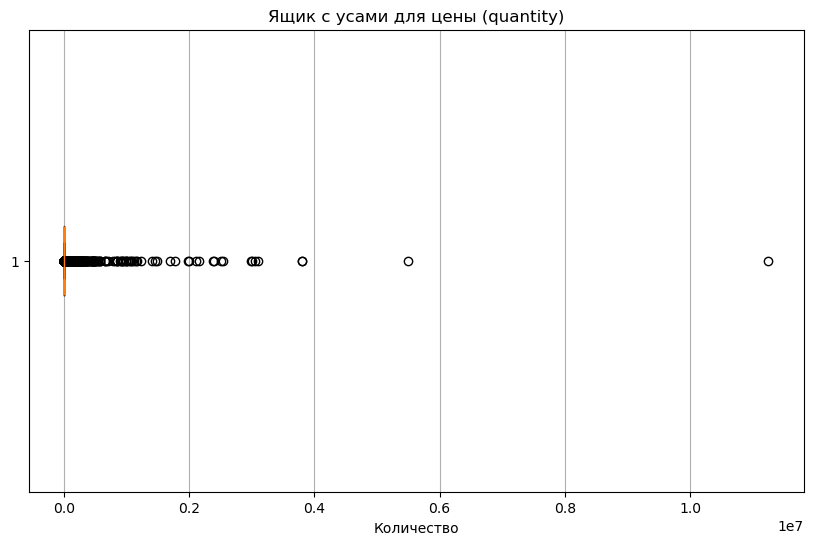

In [25]:
box_plot(data_cut['quantity'], 'Ящик с усами для цены (quantity)', 'Количество')

In [26]:
# Вычисление IQR для определения выбросов
Q1 = data_cut['quantity'].quantile(0.25)
Q3 = data_cut['quantity'].quantile(0.75)
IQR = Q3 - Q1

# Определение границ для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Удаление выбросов
data_cut = data_cut[(data_cut['quantity'] >= lower_bound) & (data_cut['quantity'] <= upper_bound)]

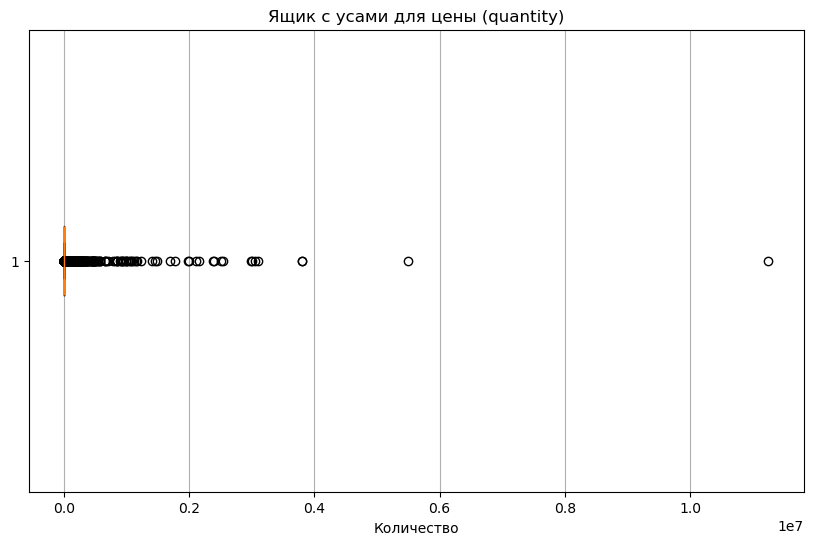

In [27]:
box_plot(data_cut['quantity'], 'Ящик с усами для цены (quantity)', 'Количество')

In [28]:
data_cut.shape

(508354, 5)

In [29]:
(data_cut[data_cut['quantity'] == 1]).shape

(508354, 5)

По одной покупают. Отрезались все нецелые значения, остались только единички.

### 6) Регионы

Посмотрим на регионы:

In [30]:
data_cut['region'].unique()

array(['Москва', 'Липецкая область', 'Нижегородская область',
       'Московская область', 'Ханты-Мансийский автономный округ',
       'Самарская область', 'Омская область', 'Краснодарский край',
       'Ульяновская область', 'Иркутская область', 'Камчатский край',
       'Ростовская область', 'Воронежская область',
       'Новосибирская область', 'Республика Башкортостан',
       'Курская область', 'Саратовская область', 'Челябинская область',
       'Санкт-Петербург', 'Архангельская область', 'Республика Марий Эл',
       'Еврейская автономная область', 'Калининградская область',
       'Амурская область', 'Ленинградская область', 'Брянская область',
       'Республика Калмыкия', 'Владимирская область',
       'Республика Саха (Якутия)', 'Ямало-Ненецкий автономный округ',
       'Тверская область', 'Смоленская область', 'Республика Коми',
       'Кировская область', 'Чувашская Республика', 'Пермский край',
       'Красноярский край', 'Белгородская область', 'Костромская область',
   

In [31]:
(data_cut['region'].unique()).shape

(83,)

Много регионов. В задании сказано для каждого предсказать, но давайте сначала один какой-нибудь возьмем. Пусть будет Нижегородская область.

In [32]:
dataNN = data_cut[data_cut['region'] == 'Нижегородская область']

In [33]:
dataNN

,Unnamed: 0,local_date,price,quantity,region
30,30,2021-02-02 00:01:49,75.0,1.0,Нижегородская область
32,32,2021-02-02 00:01:49,67.0,1.0,Нижегородская область
77,77,2021-02-02 00:06:43,57.0,1.0,Нижегородская область
173,173,2021-02-02 00:16:27,45.0,1.0,Нижегородская область
266,266,2021-02-02 00:26:37,99.0,1.0,Нижегородская область
...,...,...,...,...,...
2245507,2245507,2021-02-01 23:20:22,80.0,1.0,Нижегородская область
2245508,2245508,2021-02-01 23:20:22,80.0,1.0,Нижегородская область
2245569,2245569,2021-02-01 23:23:40,57.0,1.0,Нижегородская область
2245703,2245703,2021-02-01 23:32:48,62.0,1.0,Нижегородская область


### 7) Время

Нам нужно суммировать по часам.        
Преобразуем столбец 'local_date' к типу datetime.

In [34]:
dataNN['local_date'] = pd.to_datetime(dataNN['local_date'])

C:\Users\nicks\AppData\Local\Temp\ipykernel_12620\190126512.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataNN['local_date'] = pd.to_datetime(dataNN['local_date'])


Проверяем на всякий случай:

In [35]:
dataNN.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16037 entries, 30 to 2245704
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  16037 non-null  int64         
 1   local_date  16037 non-null  datetime64[ns]
 2   price       16037 non-null  float64       
 3   quantity    16037 non-null  float64       
 4   region      16037 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 751.7+ KB


Суммируем данные по часам:

In [36]:
# Группируем данные по часам и суммируем 'price' и 'quantity'
dataNN = dataNN.groupby(pd.Grouper(key='local_date', freq='H')).agg({'price': 'sum', 'quantity': 'sum'}).reset_index()

C:\Users\nicks\AppData\Local\Temp\ipykernel_12620\2203956842.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dataNN = dataNN.groupby(pd.Grouper(key='local_date', freq='H')).agg({'price': 'sum', 'quantity': 'sum'}).reset_index()


In [37]:
dataNN

,local_date,price,quantity
0,2020-08-03 12:00:00,79.000000,1.0
1,2020-08-03 13:00:00,0.000000,0.0
2,2020-08-03 14:00:00,0.000000,0.0
3,2020-08-03 15:00:00,0.000000,0.0
4,2020-08-03 16:00:00,0.000000,0.0
...,...,...,...
4495,2021-02-06 19:00:00,3214.000000,50.0
4496,2021-02-06 20:00:00,3255.000000,50.0
4497,2021-02-06 21:00:00,2415.000000,36.0
4498,2021-02-06 22:00:00,1645.110001,24.0


In [38]:
def plot(x, y):
    # Построение графика
    plt.figure(figsize=(12, 6))  # Устанавливаем размер графика
    plt.scatter(x, y, color='red', s=20)  # Используем scatter для точек

    # Настройка графика
    plt.title('Количество товаров по времени')
    plt.xlabel('Время')
    plt.ylabel('Количество')
    plt.xticks(rotation=45)  # Поворачиваем метки по оси X для лучшей читаемости
    plt.grid(True)  # Добавляем сетку для удобства восприятия

    # Показать график
    plt.tight_layout()  # Автоматическая подгонка элементов графика
    plt.show()

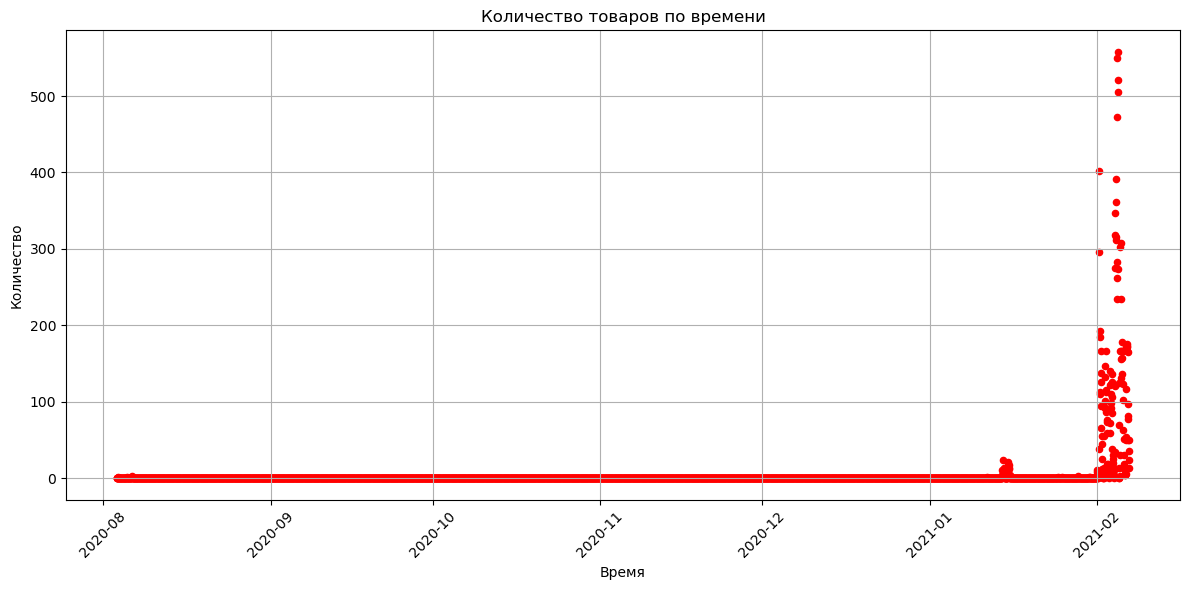

In [39]:
plot(dataNN['local_date'], dataNN['quantity'])

Ну вот что здесь?     
Мы видим, все ровно, а движения начанаются в конце. Я не знаю, почему так, почему вдруг началось это движение в феврале 21 года, а точнее, почему его не было раньше. Я думаю, просто плохие данные, как бы то ни было, нам имеет смысл смотреть только на конец графика. 

In [40]:
# Фильтруем данные, оставляя только записи с 2021 года и позже
dataNN = dataNN[dataNN['local_date'] >= '2021-01-01']

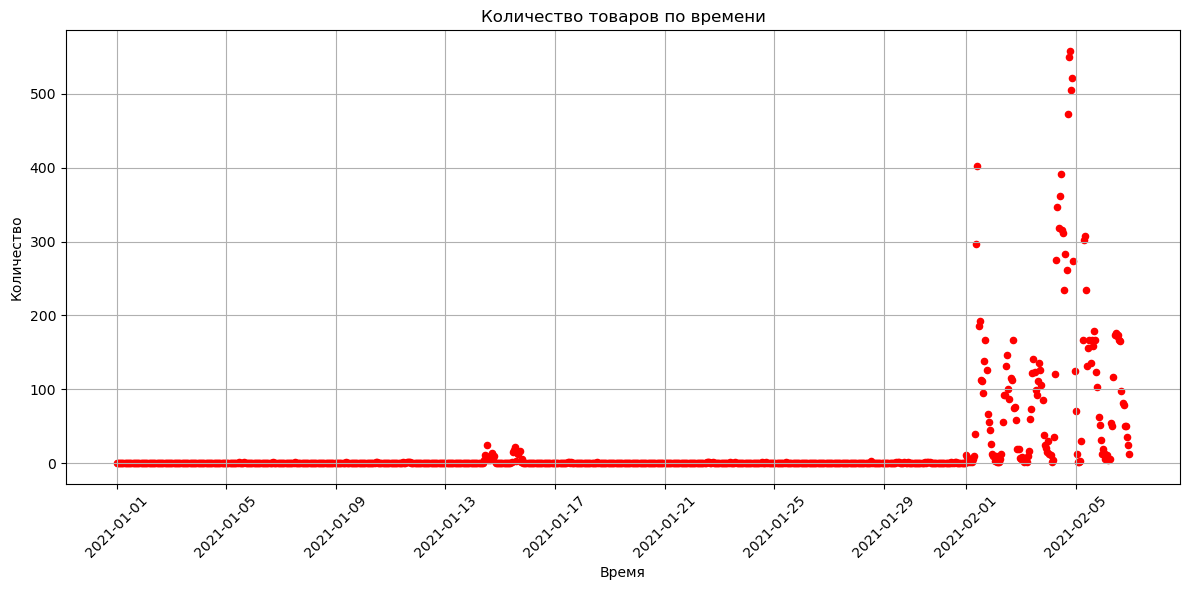

In [41]:
plot(dataNN['local_date'], dataNN['quantity'])

Отрежем ещё.

In [42]:
# Фильтруем данные, оставляя только записи с 1 февраля 2021 года и позже
dataNN = dataNN[dataNN['local_date'] >= '2021-02-01']

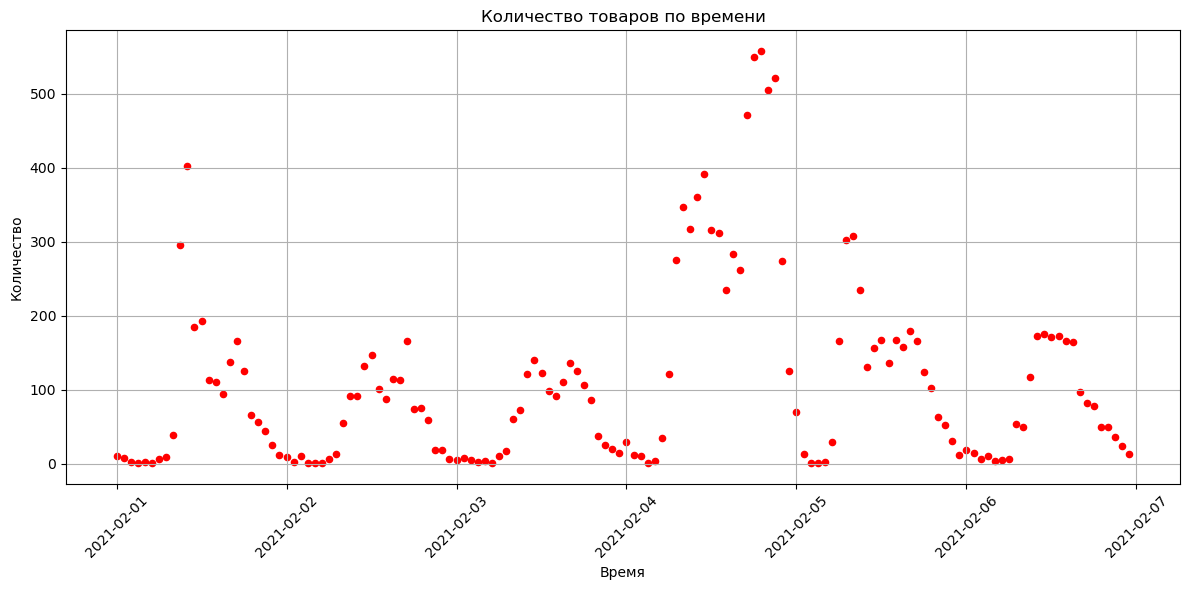

In [43]:
plot(dataNN['local_date'], dataNN['quantity'])

Отлично, вот видим периодический график.

Почему продажи полдетают 4 февраля 2021 года? Это деффект данных? Может быть это воскресенье? Или это День колы?         
День колы это 8 мая. 4 февраля 2021 года - это четверг. А вот нам надо предсказать 7-е число, воскресенье, это плохо, потому, что мы видим только будни и субботу, но в субботу продажи не взлетают. Тем не менее, у нас есть только 6 дней. Давайте посмотрим другие регионы. 

In [44]:
dataMSK = data[data['region'] == 'Москва']

In [45]:
dataMSK['local_date'] = pd.to_datetime(dataMSK['local_date'])

C:\Users\nicks\AppData\Local\Temp\ipykernel_12620\2418011266.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataMSK['local_date'] = pd.to_datetime(dataMSK['local_date'])


In [46]:
# Группируем данные по часам и суммируем 'price' и 'quantity'
dataMSK = dataMSK.groupby(pd.Grouper(key='local_date', freq='H')).agg({'price': 'sum', 'quantity': 'sum'}).reset_index()

C:\Users\nicks\AppData\Local\Temp\ipykernel_12620\1759788291.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dataMSK = dataMSK.groupby(pd.Grouper(key='local_date', freq='H')).agg({'price': 'sum', 'quantity': 'sum'}).reset_index()


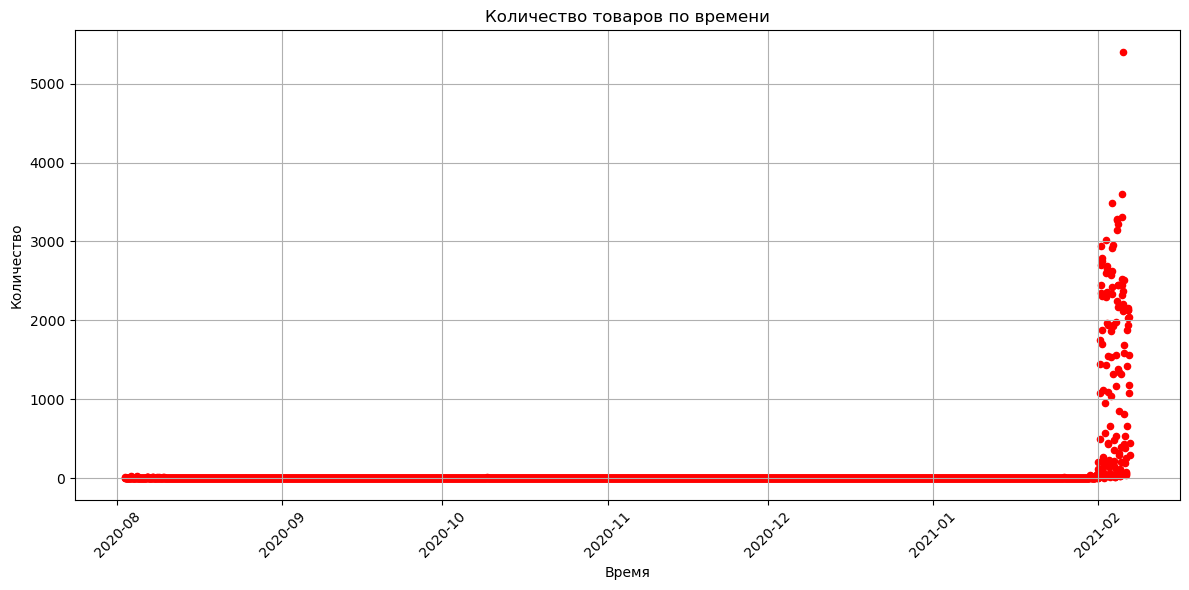

In [47]:
plot(dataMSK['local_date'], dataMSK['quantity'])

Та же картина.

In [48]:
# Фильтруем данные, оставляя только записи с 1 февраля 2021 года и позже
dataMSK = dataMSK[dataMSK['local_date'] >= '2021-02-01']

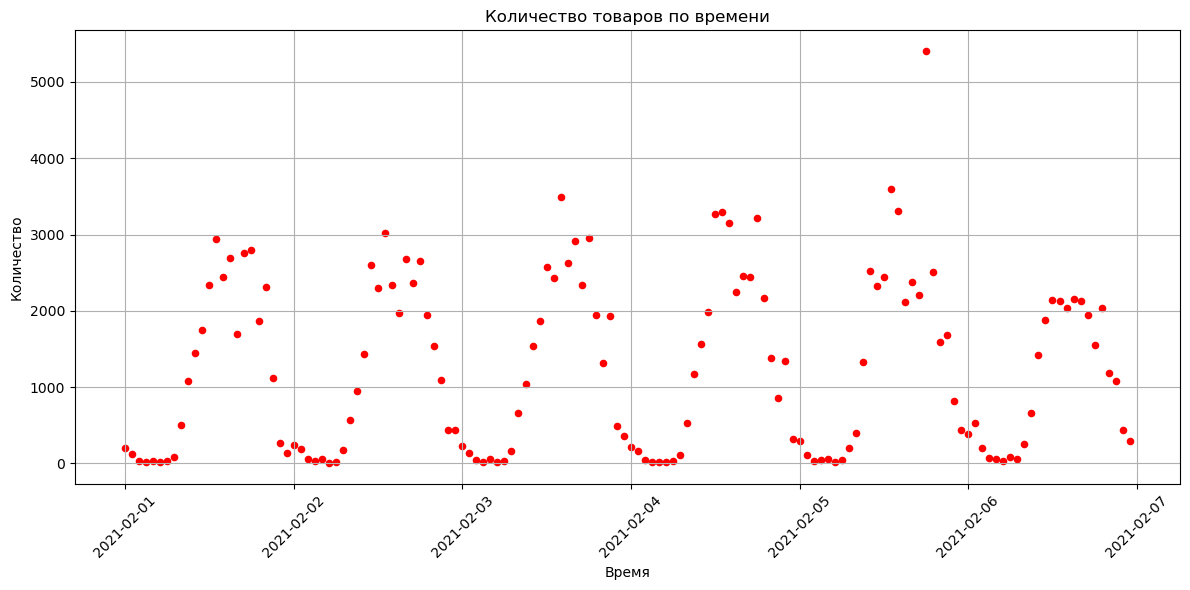

In [49]:
plot(dataMSK['local_date'], dataMSK['quantity'])

Хорошо, раз такое дело, давайте по-другому отберем данные. Давайте так, не будем вообще смотреть на цену, все равно мы ее не используем, но, может быть, там продажи будут по-другому выглядеть.           
Разберемся с продажами, сначала удалим все нецелые:

In [50]:
data = data[data['quantity'] % 1 == 0]

In [51]:
data

,Unnamed: 0,local_date,price,quantity,region
0,0,2021-02-02 00:00:01,133.0,1.0,Нижегородская область
1,1,2021-02-02 00:00:01,100.0,1.0,Нижегородская область
2,2,2021-02-02 00:00:04,50.0,1.0,Москва
3,3,2021-02-02 01:00:11,29.0,1.0,Ульяновская область
4,4,2021-02-02 00:00:17,250.0,1.0,Москва
...,...,...,...,...,...
2246087,2246087,2021-02-01 23:59:33,168.0,1.0,Республика Марий Эл
2246088,2246088,2021-02-01 23:59:35,165.0,1.0,Воронежская область
2246089,2246089,2021-02-01 23:59:35,105.0,1.0,Воронежская область
2246091,2246091,2021-02-01 23:59:42,135.0,1.0,Москва


Посмотрим вот что, сколько банок можно купить за раз в магазине (я так понимаю, покупок оптом в таблице нет)? Ну 0 нельзя купить, можно 1, 2, 3... Ну можно 10, ну 20, ну 30. Ну не больше. 

In [52]:
data = data[data['quantity'] > 0]

In [53]:
data = data[data['quantity'] <= 30]

In [54]:
data

,Unnamed: 0,local_date,price,quantity,region
0,0,2021-02-02 00:00:01,133.0,1.0,Нижегородская область
1,1,2021-02-02 00:00:01,100.0,1.0,Нижегородская область
2,2,2021-02-02 00:00:04,50.0,1.0,Москва
3,3,2021-02-02 01:00:11,29.0,1.0,Ульяновская область
4,4,2021-02-02 00:00:17,250.0,1.0,Москва
...,...,...,...,...,...
2246087,2246087,2021-02-01 23:59:33,168.0,1.0,Республика Марий Эл
2246088,2246088,2021-02-01 23:59:35,165.0,1.0,Воронежская область
2246089,2246089,2021-02-01 23:59:35,105.0,1.0,Воронежская область
2246091,2246091,2021-02-01 23:59:42,135.0,1.0,Москва


In [55]:
(data[data['quantity'] == 1]).shape

(1636592, 5)

In [56]:
data['quantity'].unique()

array([ 1.,  7.,  2.,  3.,  5., 13.,  4.,  6., 20.,  8., 15., 10., 24.,
       22., 21., 12., 25., 11., 14., 30., 18.,  9., 27., 17., 26., 19.,
       28., 16., 29., 23.])

Хорошо.

Теперь берём один регион, группируем по часам.

In [57]:
dataNN0 = data[data['region'] == 'Нижегородская область']

In [58]:
dataNN0['local_date'] = pd.to_datetime(dataNN0['local_date'])

C:\Users\nicks\AppData\Local\Temp\ipykernel_12620\860801212.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataNN0['local_date'] = pd.to_datetime(dataNN0['local_date'])


In [59]:
# Группируем данные по часам и суммируем 'price' и 'quantity'
dataNN0 = dataNN0.groupby(pd.Grouper(key='local_date', freq='H')).agg({'price': 'sum', 'quantity': 'sum'}).reset_index()

C:\Users\nicks\AppData\Local\Temp\ipykernel_12620\274256661.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dataNN0 = dataNN0.groupby(pd.Grouper(key='local_date', freq='H')).agg({'price': 'sum', 'quantity': 'sum'}).reset_index()


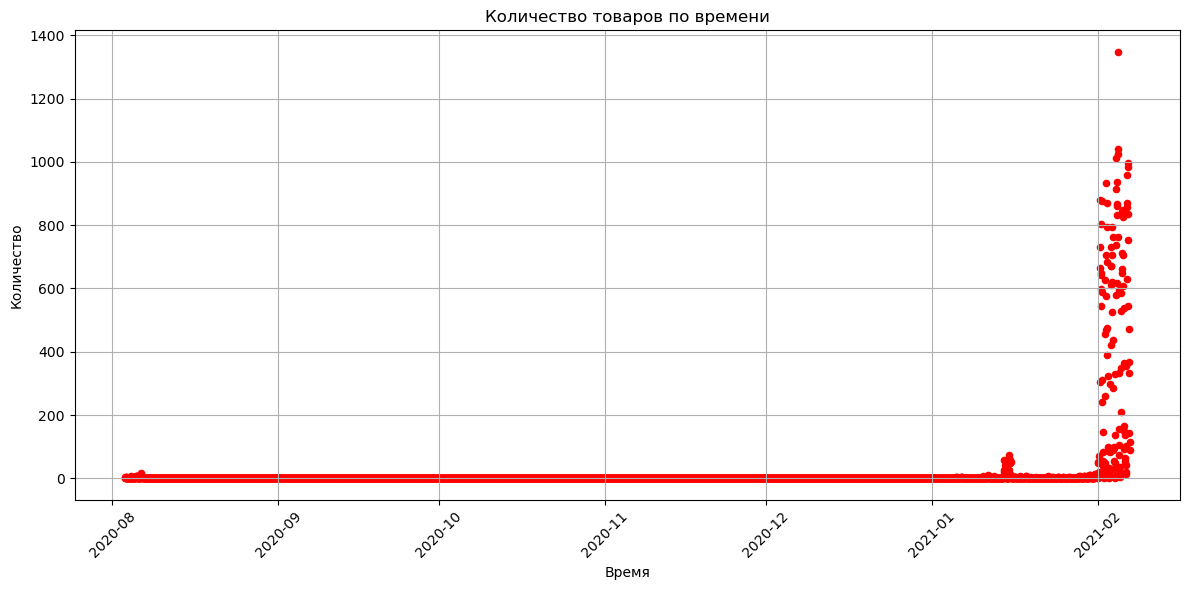

In [60]:
plot(dataNN0['local_date'], dataNN0['quantity'])

Тоже самое, просто мы не выкинули данные с неадекватной ценой и оставили покупки, где было от 1 до 30 банок.

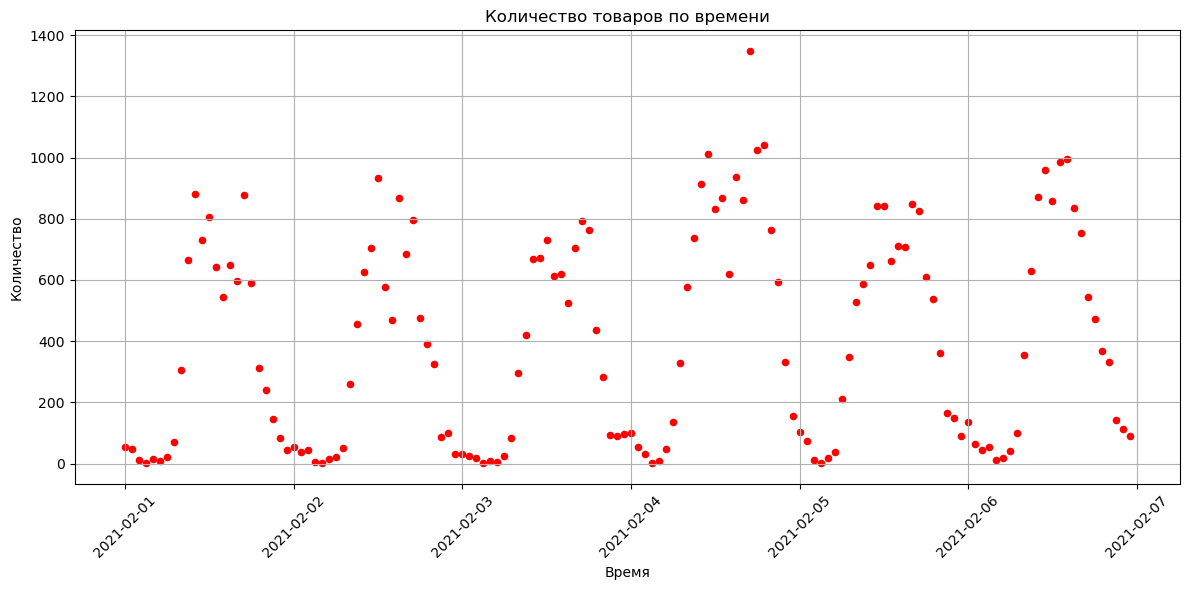

In [61]:
# Фильтруем данные, оставляя только записи с 1 февраля 2021 года и позже
dataNN0 = dataNN0[dataNN0['local_date'] >= '2021-02-01']

plot(dataNN0['local_date'], dataNN0['quantity'])

Всё тоже, только больше. Понять, как нам правильно обрезать данные, можно только доподлинно узнав, каков средний обьём продаж в день в Нижегородской области. Так мы поймем, выкидывать продажи с неадекваьной ценой или нет.

In [62]:
dataNN0

,local_date,price,quantity
4359,2021-02-01 00:00:00,5441.000000,53.0
4360,2021-02-01 01:00:00,3826.000000,48.0
4361,2021-02-01 02:00:00,1502.000000,13.0
4362,2021-02-01 03:00:00,943.000000,3.0
4363,2021-02-01 04:00:00,1256.000000,15.0
...,...,...,...
4498,2021-02-06 19:00:00,57752.320007,367.0
4499,2021-02-06 20:00:00,73997.550003,332.0
4500,2021-02-06 21:00:00,21597.010000,144.0
4501,2021-02-06 22:00:00,9502.110001,114.0


In [82]:
df1 = dataNN0[dataNN0['local_date'] >= '2021-02-06 00:00:00']
df1

,local_date,price,quantity
4479,2021-02-06 00:00:00,15847.969998,137.0
4480,2021-02-06 01:00:00,7598.000000,65.0
4481,2021-02-06 02:00:00,5593.000000,44.0
4482,2021-02-06 03:00:00,9003.000000,56.0
4483,2021-02-06 04:00:00,1622.000000,13.0
4484,2021-02-06 05:00:00,2621.000000,19.0
4485,2021-02-06 06:00:00,7089.000000,43.0
4486,2021-02-06 07:00:00,6900.739998,101.0
4487,2021-02-06 08:00:00,64136.379968,355.0
4488,2021-02-06 09:00:00,95312.539996,631.0


In [83]:
df1['quantity'].sum()

9783.0

Ну вот около 10k продано за 06.02.2021 по Нижегородской области. Похоже это на правду? Я не знаю. Погуглим...

Информации нет, посмотрим, что там, если выбрасывать надекватные цены и продажи больше одной банки за раз:

In [81]:
df0 = dataNN[dataNN['local_date'] >= '2021-02-06 00:00:00']
df0['quantity'].sum()

1741.0

Ну вот гораздо меньше, как прикинуть, что правильнее? Я думаю, цифра 10k более реалистичная. С ней и будем работать.

Всё, осталось только обучить какую-нибудь модель на таблице dataNN0 и предсказать 7-е число. Пока посмотрим на продажи по-ближе:

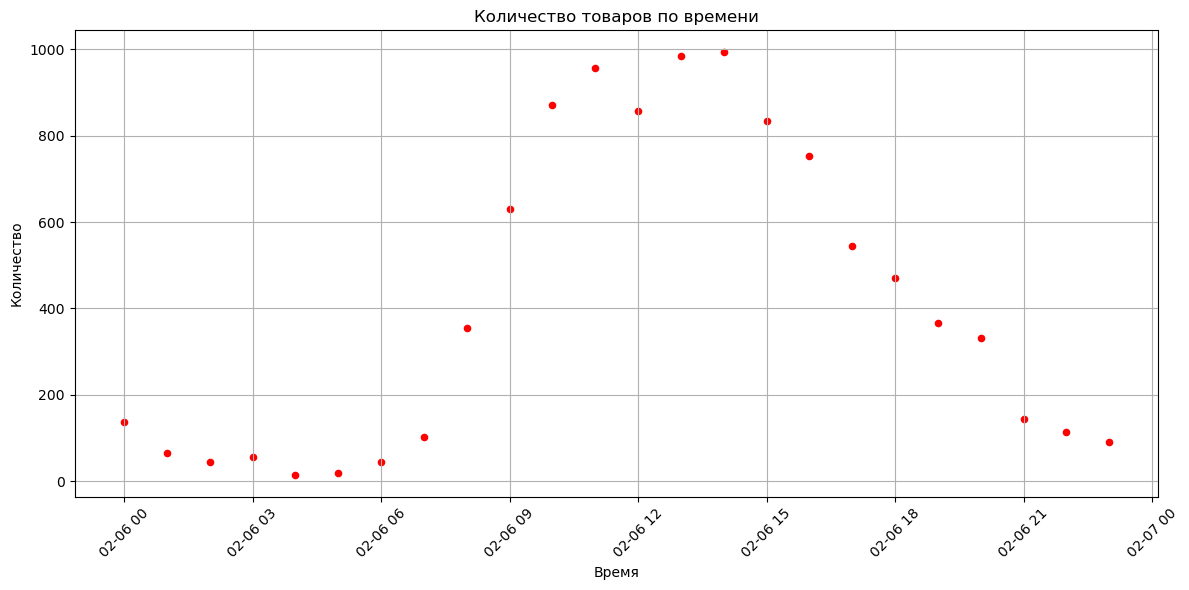

In [84]:
plot(df1['local_date'], df1['quantity'])

Ну тут все видно, ночью, с 00:00 до 06:00 продаж стабильно мало. С утра они растут, пик приходится где то на 14:00. В 12:00 странная просадка, причем похоже, что она есть во все дни (возможно это связано с тем, что это время обеда, не знаю). С 15:00 до 00:00 продажи падают.

Конечно, так как наша модель увидит только 6 дней и не увидит воскресенься, она просто выдаст то же самое, что и в прочие дни. Так что наверное, было бы правильнее в данной конкретной задаче просто поститать среднее (мат. ож-е) по часам и сказать, что так оно и будет. Но мы используем какую-нибудь ML модель.

In [70]:
dataNN0.shape

(144, 3)

In [118]:
import numpy as np

Сделаем train и test. Возьмем первые пять дней и последние пять дней, то есть train и test - это одно и то же, только со сдвигом в одни сутки.

In [102]:
from sklearn import linear_model

train_X = dataNN0[dataNN0['local_date'] < '2021-02-06 00:00:00']
train_X = train_X['quantity']
train_X = np.array(train_X)
train_X = train_X.reshape(-1, 1)

train_y = dataNN0[dataNN0['local_date'] > '2021-02-01 23:00:00']
train_y = train_y['quantity']
train_y = np.array(train_y)
train_y = train_y.reshape(-1, 1)

test_X = train_y

train_X

array([[  53.],
       [  48.],
       [  13.],
       [   3.],
       [  15.],
       [  10.],
       [  21.],
       [  70.],
       [ 305.],
       [ 666.],
       [ 880.],
       [ 730.],
       [ 805.],
       [ 641.],
       [ 545.],
       [ 650.],
       [ 598.],
       [ 877.],
       [ 590.],
       [ 311.],
       [ 242.],
       [ 146.],
       [  84.],
       [  44.],
       [  56.],
       [  39.],
       [  45.],
       [   5.],
       [   2.],
       [  15.],
       [  23.],
       [  50.],
       [ 260.],
       [ 456.],
       [ 626.],
       [ 706.],
       [ 934.],
       [ 577.],
       [ 470.],
       [ 869.],
       [ 685.],
       [ 795.],
       [ 475.],
       [ 390.],
       [ 325.],
       [  87.],
       [  99.],
       [  31.],
       [  32.],
       [  26.],
       [  19.],
       [   2.],
       [   8.],
       [   5.],
       [  25.],
       [  84.],
       [ 297.],
       [ 420.],
       [ 670.],
       [ 672.],
       [ 731.],
       [ 612.],
       [

Вольмём регрессию Лассо:

In [116]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(train_X, train_y)
pred = reg.predict(test_X)

In [121]:
pred.shape

(120,)

In [117]:
pred

array([ 114.60367531,   99.92868748,  105.10809495,   70.5787118 ,
         67.98900806,   79.21105759,   86.11693422,  109.42426784,
        290.70352938,  459.89750681,  606.6473852 ,  675.7061515 ,
        872.52363545,  564.34889084,  471.98279092,  816.41338783,
        657.57822535,  752.53402901,  476.29896381,  402.92402462,
        346.813777  ,  141.36394726,  151.7227622 ,   93.02281085,
         93.88604542,   88.70663795,   82.6639959 ,   67.98900806,
         73.16841553,   70.5787118 ,   87.84340337,  138.77424352,
        322.64320879,  428.82106198,  644.62970666,  646.35617582,
        697.28701597,  594.5621011 ,  602.33121231,  519.46069275,
        674.84291692,  751.67079443,  725.77375707,  444.3592844 ,
        311.42115927,  148.26982389,  144.81688557,  149.13305846,
        152.58599678,  114.60367531,   93.02281085,   67.98900806,
         74.03165011,  107.69779868,  183.66244161,  351.12994989,
        565.21212542,  703.32965802,  856.12217846,  940.71916

In [123]:
test = pd.date_range(start='2021-02-03 00:00:00', end='2021-02-07 23:00:00', freq='H')
test = pd.DataFrame({
    'local_date': test
})

C:\Users\nicks\AppData\Local\Temp\ipykernel_12620\3357139386.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  test = pd.date_range(start='2021-02-03 00:00:00', end='2021-02-07 23:00:00', freq='H')


In [124]:
test.shape

(120, 1)

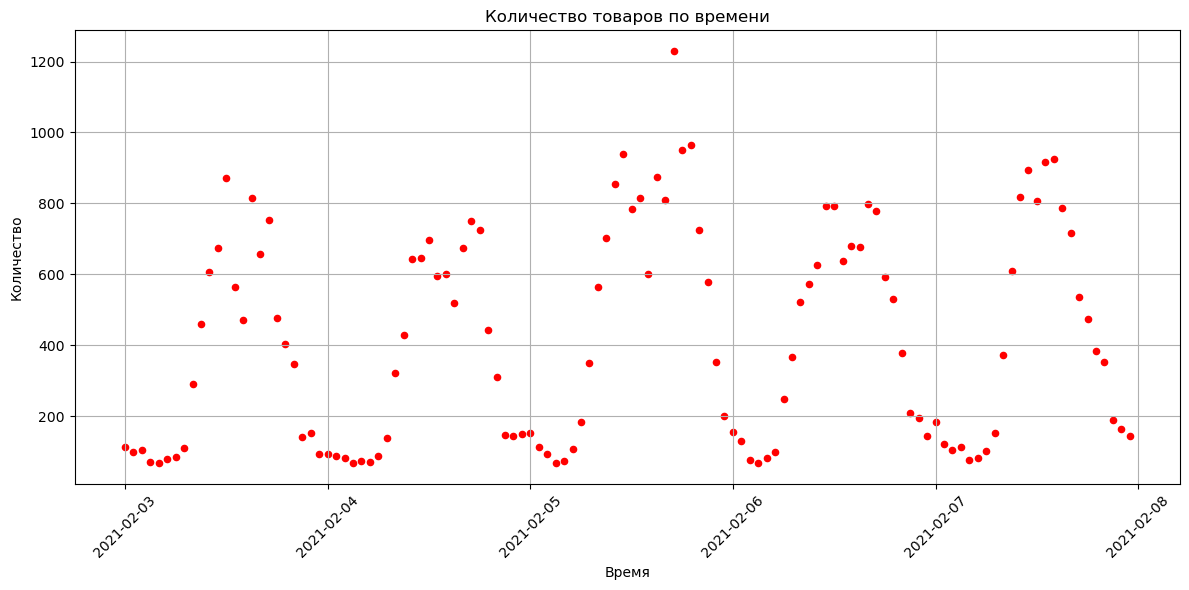

In [125]:
plot(test, pred)

Ну вот он, седьмой день.